### `skimage`

The [`skimage` (scikit-image)](https://scikit-image.org/docs/stable/overview.html) Python package provides a wide range of image processing tools.

# Art Overview

At first glance, it might appear unusual to think that interactive computing and single piece generative document workflows might have anything to offer to courses in art and art history.

But with a little bit of creative thought, we see how we can create a range of production related tools that provide flexibility in creating asssets that can be usefully discussed in a narrative context, as well as offering students to those same tools of production for use as independent curiosoty driven learning tools.

```{note}
Several of the tools presented in this notebook were first introduced in [*
Build Your Own Learning Tools (BYOT)*](https://blog.ouseful.info/2018/09/06/build-your-own-learning-tools/).
```

See also the section on *images* for more examples of image processing tools.

In [1]:
%%capture
try:
    import skimage
except:
    %pip install scikit-image

In [2]:
import skimage

Colour wheels are often used to represent the relationship between different colours in "color space". For example, the following colour wheel is taken fron an OU / OpenLearn art history unit ([Making sense of art history](https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.3)):

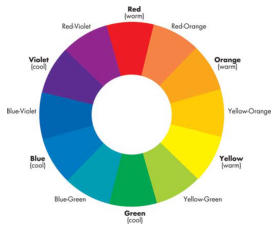

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt

# Image from https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.3
url_color_wheel='y180_2_001i.jpg'
color_wheel = imread(url_color_wheel)
plt.imshow(color_wheel)
plt.axis('off');

The first thing to notice about this colour wheel is that is provided as an image in its own right. So might we be able to analyse / process that image in a useful way?

How about if we try to filter the image to only show colours that are blue, or at least, blue-ish?

In [4]:
from skimage import io, color, exposure, img_as_float
import matplotlib.pyplot as plt

#https://stackoverflow.com/a/21661395/454773
#can we generalise this to easily specify eg red, green blue, or other point on colour wheel?
#so for example, we might have a slider along ROYGBIV to let us select a hue
#and maybe a slider to select the "width"?
#(Do ipywidgets support range sliders?)
def get_blues(image):
    ''' Function to filter an image to only show blue / blue-ish components. '''
    
    blue_lab = color.rgb2lab([[[0, 0, 1.]]])
    light_blue_lab = color.rgb2lab([[[0, 1, 1.]]])
    red_lab = color.rgb2lab([[[1, 0, 0.]]])
    image_lab = color.rgb2lab(image)

    distance_blue = color.deltaE_cmc(blue_lab, image_lab, kL=0.5, kC=0.5)
    distance_light_blue = color.deltaE_cmc(light_blue_lab, image_lab, kL=0.5, kC=0.5)
    distance_red = color.deltaE_cmc(red_lab, image_lab, kL=0.5, kC=0.5)
    distance = distance_blue + distance_light_blue - distance_red
    distance = exposure.rescale_intensity(distance)

    image_blue = image.copy()
    image_blue[distance > 0.3] = 0

    image_blue = image.copy()
    image_blue[distance > 0.3] = 0


    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
    ax0.imshow(image)
    ax1.imshow(distance, cmap='gray')
    ax2.imshow(image_blue)
    plt.show()

We can now view a processed version of the original image, providing a black and white (greyscale) rendering of it, along with a segment showing just part of the colour map:

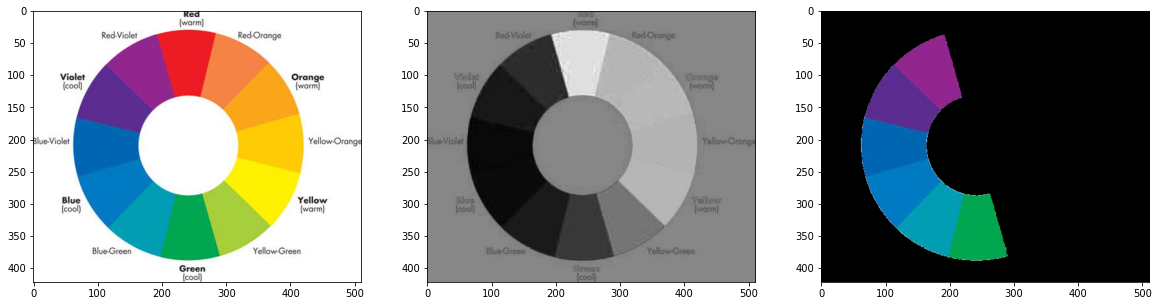

In [5]:
get_blues(color_wheel)

We can now also try to create our own dynamically created colour wheel:

In [6]:
%%capture
try:
    import PIL
except:
    %pip install Pillow

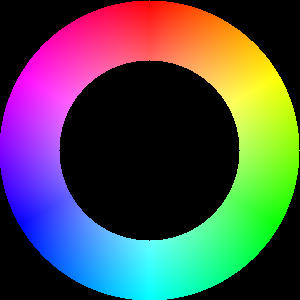

In [7]:
#If we're doing a reproducible thing, then let's create a color wheel...
#https://rosettacode.org/wiki/Color_wheel
from PIL import Image
import colorsys
import math


def createColourWheel(size=(300,300), angle=0 ):
    ''' Create a colour wheel. '''
    im = Image.new("RGB", size)
    radius = min(im.size)/2.0
    centre = im.size[0]/2, im.size[1]/2
    pix = im.load()

    for x in range(im.width):
        for y in range(im.height):
            rx = x - centre[0]
            ry = y - centre[1]
            s = ((x - centre[0])**2.0 + (y - centre[1])**2.0)**0.5 / radius
            if s <= 1.0 and s>0.6:
                h = ((math.atan2(ry, rx) / math.pi) + 1.0) / 2.0
                rgb = colorsys.hsv_to_rgb(h, s, 1.0)
                pix[x,y] = tuple([int(round(c*255.0)) for c in rgb])

    #We can rotate and resize the PIL image directly
    im = im.rotate(angle, expand=1 )
    
    #We can also do thngs like resize the image
    #im = im.resize(size)
    
    return im

im = createColourWheel(angle=-90)
im
#The image looks a bit ragged to me? We maybe need to up the size?

Again, we can filter on just part of the colour range:

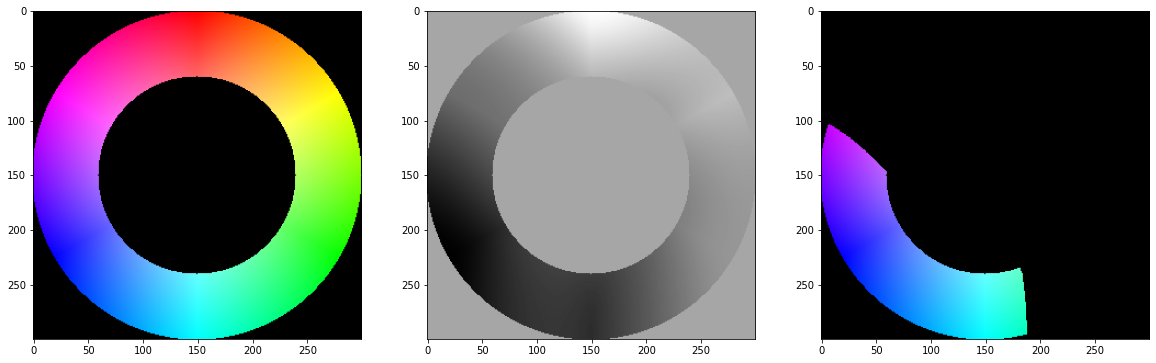

In [8]:
import numpy

get_blues(numpy.array(im))

The notebooks provide us with a computational medium that allows us analyse images programmatically. So can we start to analyse images in a way that contributes to the learning objectives of a course?

For example, the OpenLearn unit asks "*Are the colours largely bright or dull?*" in some example pictures. If "bright" and "dull" are physically meaningful terms, can we measure these dimensions, and create a simple tool that lets students look at arbitrary pictures and check their interpretation of them against the machine's interpretation, accroding to a particular measure?

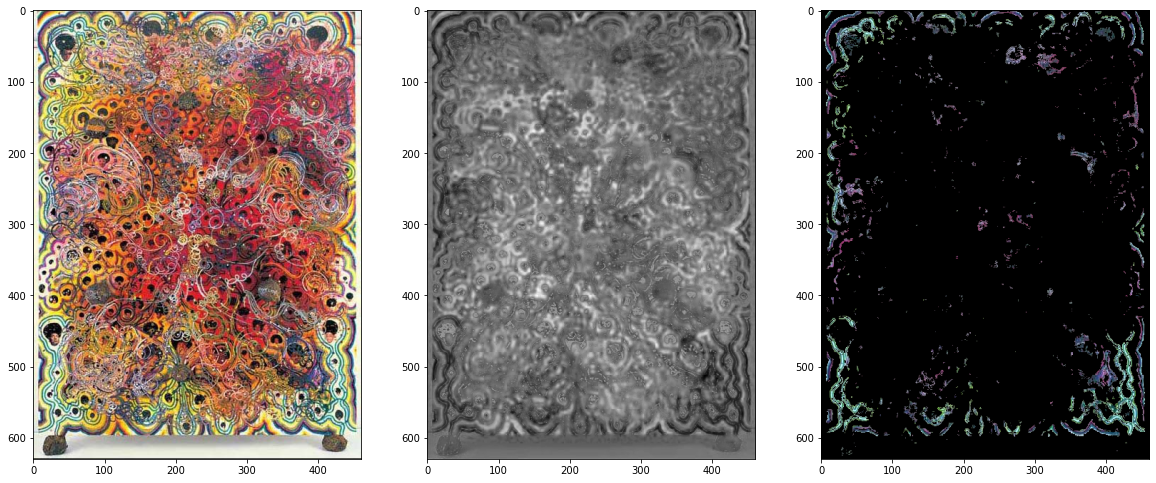

In [9]:
#Image from https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.6
orange_image_file = 'plate10.jpg'

orange_image = imread(orange_image_file)
get_blues(orange_image)

How about a picture that does have a blue theme?

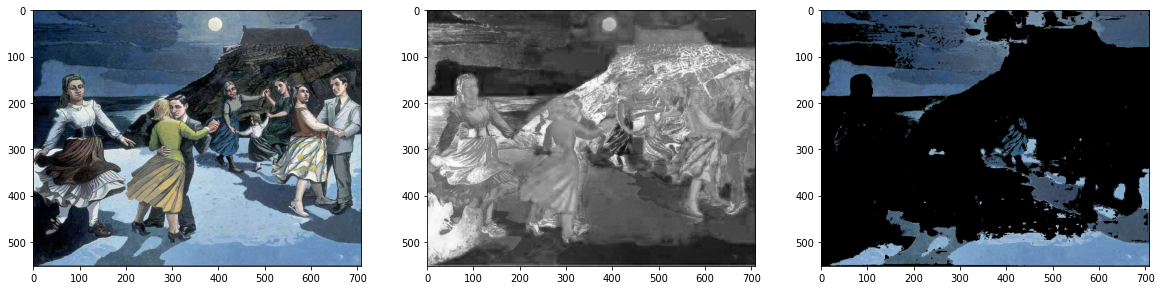

In [10]:
#Image from https://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.6
blue_image_file = 'plate14.jpg'

blue_image = imread(blue_image_file)
get_blues(blue_image)

## Finding Dominant Colour

Perhaps more useful would be something that lets us extract the dominant colour from an image?

```{note}
See also the *image* notebook for an alternative way of analysing these images in terms of colour and brightness.
```

A naive approach would be to simply calculate the "average" pixel colour value, but this loses the sense of the actual colours contained in a picture. Instead, we can use a clustering technique to try to identify colour values that appear most frequently in a picture.

In [11]:
##https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar


#Use kmeans clustering to find dominant colour values
from IPython.display import display, Image
from skimage.io import imread
def palettiser1(fp, k=3):
    if fp.startswith('http'):
        image = imread(fp)
    else:
        image = cv2.imread(fp)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    img = image.reshape((image.shape[0] * image.shape[1],3)) #represent as row*column,channel number
    clt = KMeans(n_clusters=k) #cluster number
    clt.fit(img)

    hist = find_histogram(clt)
    bar = plot_colors2(hist, clt.cluster_centers_)

    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    plt.imshow(image)
    
#This https://zeevgilovitz.com/detecting-dominant-colours-in-python may be handy
#as an example of how to add a colour palette band to the side of the image?

Let's view our image through this "palettiser" tool:

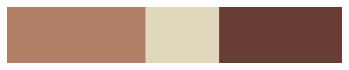

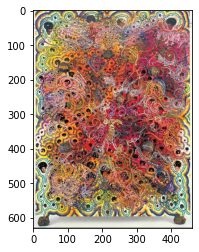

In [12]:
palettiser1(orange_image_file)

We can also generate a palette containing a specified number of dominant colours:

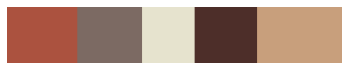

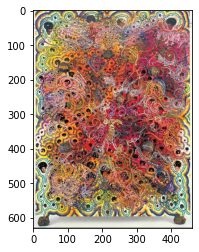

In [13]:
palettiser1(orange_image_file, 5)

### `colorthief`

THe `colorthief` package provides a range of tools for extracting the dominant colour from an image.

For example, how does it see our first image?

In [14]:
%%capture
#colorthief - https://github.com/fengsp/color-thief-py
#Grabs the dominant color or a representative color palette from an image. 
try:
    import colorthief
except:
    %pip install colorthief

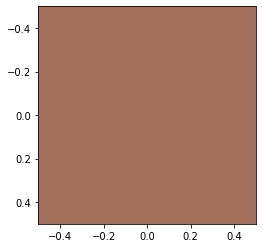

In [15]:
from colorthief import ColorThief

color_thief = ColorThief(orange_image_file)

#Dominant colour
c=color_thief.get_color(quality=1)
plt.imshow([[tuple(col/255 for col in c)]]);

And how about the other image?

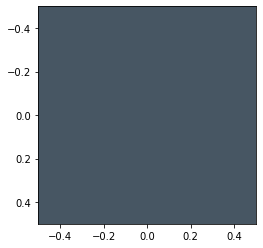

In [16]:
color_thief = ColorThief(blue_image_file)

#Dominant colour
c = color_thief.get_color(quality=1)
plt.imshow([[tuple(col/255 for col in c)]]);

The `colorthief` package also has a palettiser function.

Let's see how it interprets the second (blue themed) image:

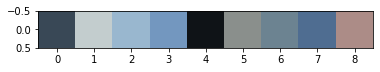

In [17]:
#palette
c2 = color_thief.get_palette(color_count=10)

plt.imshow([[tuple(col/255 for col in c) for c in c2]]);

We can use the `colorthief` code as part of our own revised palettiser function to preview the file along with the palette.

In [18]:
def palettiser2(fp, p=6):
    color_thief = ColorThief(fp)
    
    c2 = color_thief.get_palette(color_count=p)
    plt.imshow([[tuple(col/255 for col in c) for c in c2]])
    plt.show()
    
    image = cv2.imread(fp)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image);

Let's see how it works with the second image:

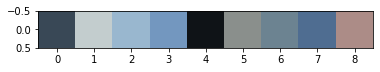

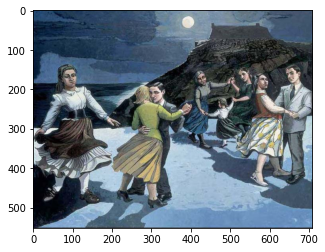

In [19]:
palettiser2(blue_image_file, 10)

And the first:

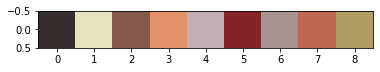

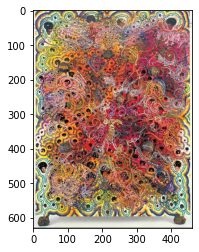

In [20]:
palettiser2(orange_image_file, 10)